In [1]:
import polars as pl

import faiss
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [2]:
SEED = 4001

In [3]:
beats_df = pl.read_parquet("./data/beats.pqt.zst")
print(beats_df.shape)
display(beats_df.sample(5))

(8995883, 3)


signal,symbol,is_arrhythmia
list[f64],str,bool
"[0.039566, 0.039173, … -0.009948]","""N""",false
"[-0.018258, -0.02829, … 0.041088]","""N""",false
"[-0.016364, 0.012732, … -0.003282]","""N""",false
"[-0.057869, -0.0736, … 0.096109]","""N""",false
"[0.018049, 0.025922, … 0.03989]","""N""",false


In [4]:
unbalanced_df = beats_df.sample(300000, shuffle=True, seed=SEED)

a_samples = beats_df.filter(pl.col("symbol") == "A").sample(100000, shuffle=True, seed=SEED)
v_samples = beats_df.filter(pl.col("symbol") == "V").sample(100000, shuffle=True, seed=SEED)
n_samples = beats_df.filter(pl.col("symbol") == "N").sample(100000, shuffle=True, seed=SEED)

balanced_111_df = pl.concat([a_samples, v_samples, n_samples]).sample(fraction=1, shuffle=True, seed=SEED)

a_samples = beats_df.filter(pl.col("symbol") == "A").sample(75000, shuffle=True, seed=SEED)
v_samples = beats_df.filter(pl.col("symbol") == "V").sample(75000, shuffle=True, seed=SEED)
n_samples = beats_df.filter(pl.col("symbol") == "N").sample(150000, shuffle=True, seed=SEED)

balanced_112_df = pl.concat([a_samples, v_samples, n_samples]).sample(fraction=1, shuffle=True, seed=SEED)

In [5]:

def get_x_y(df: pl.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    X = np.stack(df['signal'].to_numpy())
    y = df['is_arrhythmia'].to_numpy()
    return X, y

def split_dataset(df: pl.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    train, test = train_test_split(df, 
                                test_size=0.2, random_state=SEED)
    validation, test = train_test_split(test, test_size=0.5, random_state=SEED)

    return *get_x_y(train), *get_x_y(validation), *get_x_y(test)

train_X, train_y, val_X, val_y, test_X, test_y = split_dataset(unbalanced_df)
train_bal_111_X, train_bal_111_y, val_bal_111_X, val_bal_111_y, test_bal_111_X, test_bal_111_y = split_dataset(balanced_111_df)
train_bal_112_X, train_bal_112_y, val_bal_112_X, val_bal_112_y, test_bal_112_X, test_bal_112_y = split_dataset(balanced_112_df)

In [6]:
# Create a test set following the overall beats distribution
test_full = beats_df.sample(50000, shuffle=True, seed=SEED)
test_full_X = np.stack(test_full['signal'].to_numpy())
test_full_y = test_full['is_arrhythmia'].to_numpy()

In [7]:
print(f"Ratio of abnormal samples in unbalanced dataset: {(sum(train_y) / len(train_y)):.2%}")
print(f"Ratio of abnormal samples in balanced 1-1-1 dataset: {(sum(train_bal_111_y) / len(train_bal_111_y)):.2%}")
print(f"Ratio of abnormal samples in balanced 1-1-2 dataset: {(sum(train_bal_112_y) / len(train_bal_112_y)):.2%}")

print("Unbalanced dataset shapes:")
print(train_X.shape)

print("Balanced 1-1-1 dataset shapes:")
print(train_bal_111_X.shape)

print("Balanced 1-1-2 dataset shapes:")
print(train_bal_112_X.shape)

Ratio of abnormal samples in unbalanced dataset: 3.18%
Ratio of abnormal samples in balanced 1-1-1 dataset: 66.66%
Ratio of abnormal samples in balanced 1-1-2 dataset: 50.02%
Unbalanced dataset shapes:
(240000, 96)
Balanced 1-1-1 dataset shapes:
(240000, 96)
Balanced 1-1-2 dataset shapes:
(240000, 96)


In [8]:
res = faiss.StandardGpuResources()

class FaissKNN:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, x, y):
        self.index = faiss.IndexFlatL2(x.shape[1])
        self.index = faiss.index_cpu_to_gpu(res, 0, self.index)

        self.index.add(x.astype(np.float32))
        self.y = y

    def predict(self, x, threshold=0.5):
        _, indices = self.index.search(x.astype(np.float32), k=self.k)
        votes = self.y[indices]

        positive_proportions = np.mean(votes, axis=1)
        
        predictions = (positive_proportions >= threshold).astype(int)
        
        return predictions

In [9]:
knn_bal_111 = FaissKNN(k=100)
knn_bal_111.fit(train_bal_111_X, train_bal_111_y)

knn_bal_112 = FaissKNN(k=100)
knn_bal_112.fit(train_bal_112_X, train_bal_112_y)

knn_unbal = FaissKNN(k=100)
knn_unbal.fit(train_X, train_y)

In [10]:
def search_k(model: FaissKNN, val_X: np.ndarray, val_y: np.ndarray, min_k: int, max_k: int):
    dict_k = {}
    max_f1 = 0
    best_k = 0
    for i in tqdm(range(min_k, max_k + 1), desc="Searching for best k", leave=False):
        model.k = i
        pred_y = model.predict(val_X)
        f1 = f1_score(val_y, pred_y)
        dict_k[i] = f1
        if f1 > max_f1:
            max_f1 = f1
            best_k = i

    return dict_k, best_k
    
def model_stats(model: FaissKNN, x: np.ndarray, y: np.ndarray, k: int, name: str):
    model.k = k
    pred_y = model.predict(x)

    print()
    print(f"{'-'*10} Results for {name} model with k={k} {'-'*10}")

    rep = classification_report(y, pred_y)
    cm = confusion_matrix(y, pred_y)

    print(rep)

    # Plot confusion matrix with seaborn
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for ' + name)
    plt.show()

Searching for best k:   0%|          | 0/20 [00:00<?, ?it/s]

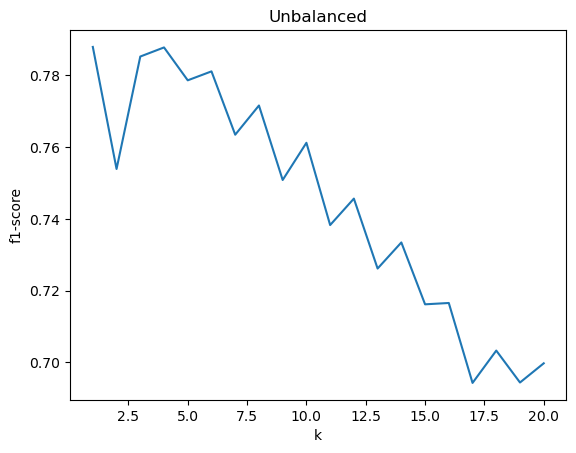

Searching for best k:   0%|          | 0/20 [00:00<?, ?it/s]

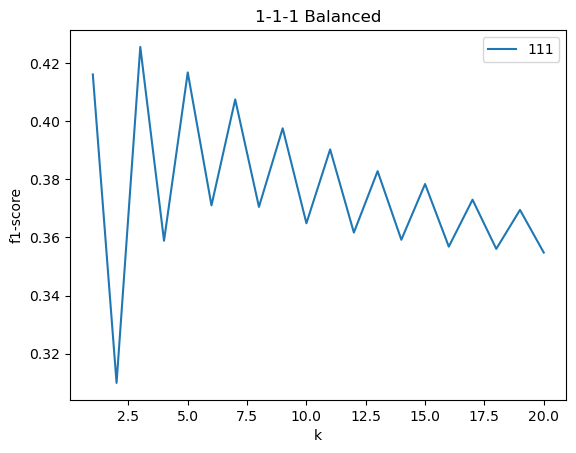

Searching for best k:   0%|          | 0/20 [00:00<?, ?it/s]

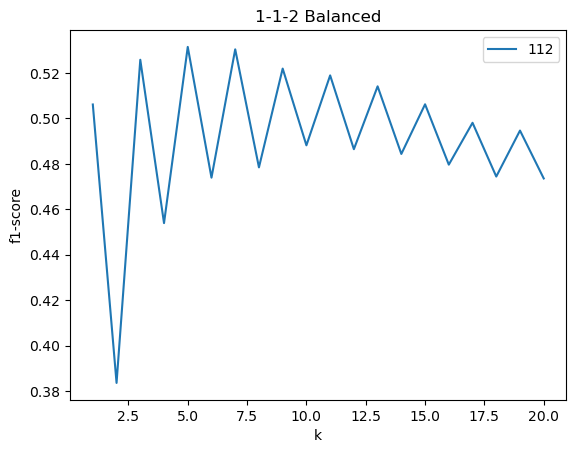

In [11]:
unbal_k, unbal_best_k = search_k(knn_unbal, val_X, val_y, 1, 20)
sns.lineplot(x=unbal_k.keys(), y=unbal_k.values()) 
plt.title('Unbalanced')
plt.xlabel('k')
plt.ylabel('f1-score')
plt.show()

bal_111_k, bal_111_best_k = search_k(knn_bal_111, val_X, val_y, 1, 20)
sns.lineplot(x=bal_111_k.keys(), y=bal_111_k.values(), label='111') 
plt.title('1-1-1 Balanced')
plt.xlabel('k')
plt.ylabel('f1-score')
plt.show()

bal_112_k, bal_112_best_k = search_k(knn_bal_112, val_X, val_y, 1, 20)
sns.lineplot(x=bal_112_k.keys(), y=bal_112_k.values(), label='112')
plt.title('1-1-2 Balanced')
plt.xlabel('k')
plt.ylabel('f1-score')
plt.show()


---------- Results for Unbalanced Test model with k=1 ----------
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     29049
        True       0.81      0.76      0.78       951

    accuracy                           0.99     30000
   macro avg       0.90      0.88      0.89     30000
weighted avg       0.99      0.99      0.99     30000



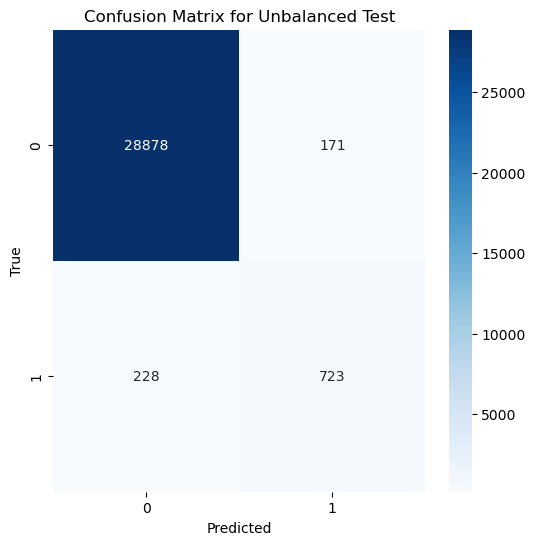


---------- Results for Balanced 1-1-1 Test (Balanced Sample) model with k=3 ----------
              precision    recall  f1-score   support

       False       0.94      0.92      0.93      9916
        True       0.96      0.97      0.96     20084

    accuracy                           0.95     30000
   macro avg       0.95      0.94      0.95     30000
weighted avg       0.95      0.95      0.95     30000



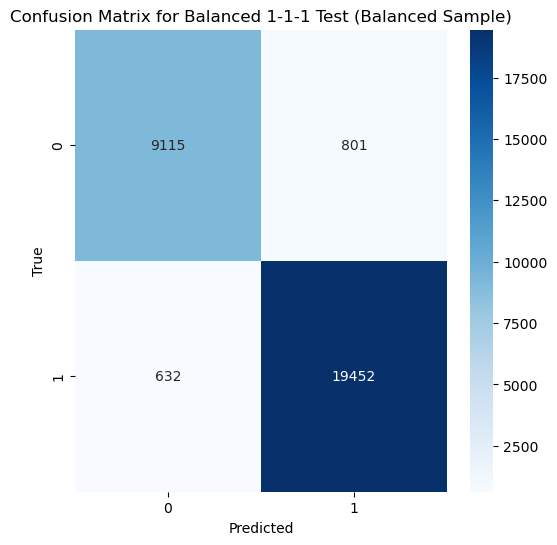


---------- Results for Balanced 1-1-2 Test (Balanced Sample) model with k=5 ----------
              precision    recall  f1-score   support

       False       0.95      0.95      0.95     15015
        True       0.95      0.95      0.95     14985

    accuracy                           0.95     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.95      0.95      0.95     30000



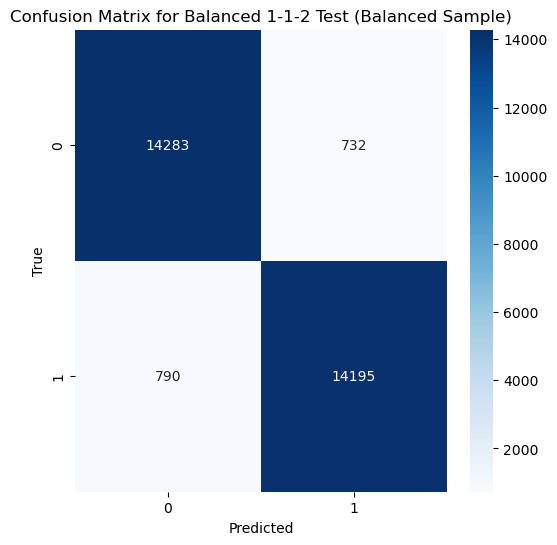


---------- Results for Unbalanced Test (Unbalanced Sample) model with k=1 ----------
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     48403
        True       0.80      0.77      0.78      1597

    accuracy                           0.99     50000
   macro avg       0.90      0.88      0.89     50000
weighted avg       0.99      0.99      0.99     50000



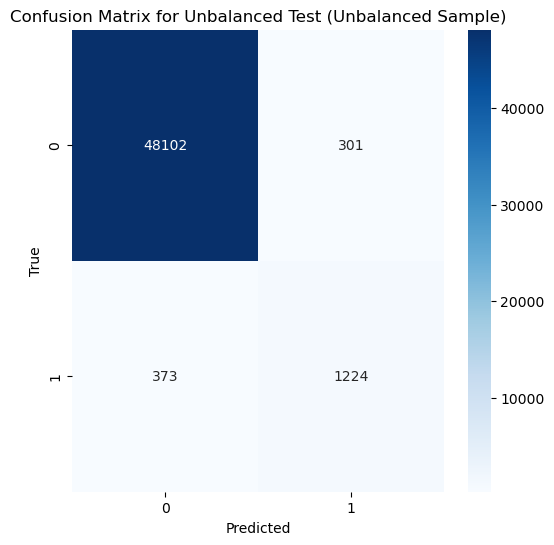


---------- Results for Balanced 1-1-1 Test (Unbalanced Sample) model with k=3 ----------
              precision    recall  f1-score   support

       False       1.00      0.92      0.96     48403
        True       0.29      0.98      0.45      1597

    accuracy                           0.92     50000
   macro avg       0.65      0.95      0.70     50000
weighted avg       0.98      0.92      0.94     50000



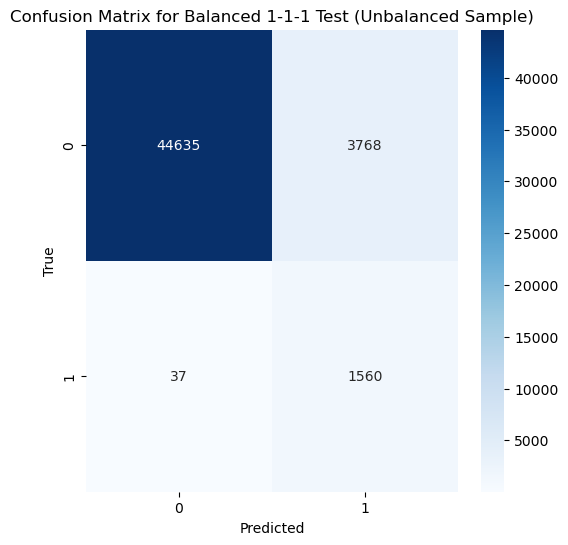


---------- Results for Balanced 1-1-2 Test (Unbalanced Sample) model with k=5 ----------
              precision    recall  f1-score   support

       False       1.00      0.95      0.97     48403
        True       0.40      0.96      0.56      1597

    accuracy                           0.95     50000
   macro avg       0.70      0.96      0.77     50000
weighted avg       0.98      0.95      0.96     50000



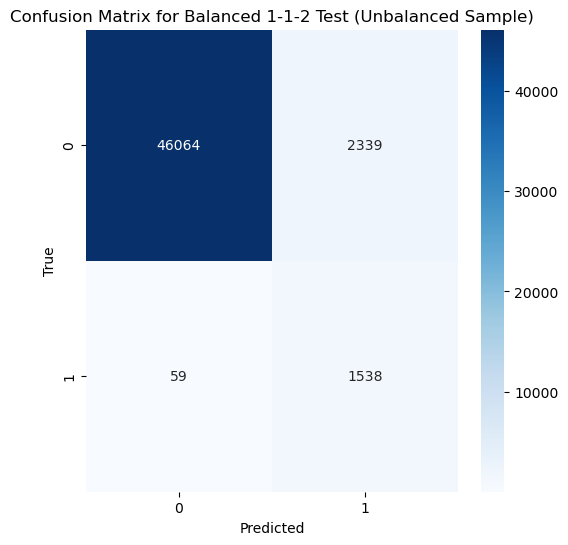

In [12]:
model_stats(knn_unbal, test_X, test_y, k=unbal_best_k, name="Unbalanced Test")
model_stats(knn_bal_111, test_bal_111_X, test_bal_111_y, k=bal_111_best_k, name="Balanced 1-1-1 Test (Balanced Sample)")
model_stats(knn_bal_112, test_bal_112_X, test_bal_112_y, k=bal_112_best_k, name="Balanced 1-1-2 Test (Balanced Sample)")

model_stats(knn_unbal, test_full_X, test_full_y, k=unbal_best_k, name="Unbalanced Test (Unbalanced Sample)")
model_stats(knn_bal_111, test_full_X, test_full_y, k=bal_111_best_k, name="Balanced 1-1-1 Test (Unbalanced Sample)")
model_stats(knn_bal_112, test_full_X, test_full_y, k=bal_112_best_k, name="Balanced 1-1-2 Test (Unbalanced Sample)")